# Introduction

In this project, we are going to use spacy for entity recognition on 200 Resume and experiment around various NLP tools for text analysis. The main purpose of this project is to help recruiters go throwing hundreds of applications within a few minutes. We have also added skills match feature so that hiring managers can follow a metric that will help them to decide whether they should move to the interview stage or not. We will be using two datasets; the first contains resume texts and the second contains skills that we will use to create an entity ruler.

# Dataset

A collection of 2400+ Resume Examples taken from livecareer.com for categorizing a given resume into any of the labels defined in the dataset:https://www.kaggle.com/snehaanbhawal/resume-dataset

# Inside the csv

•ID: Unique identifier and file name for the respective pdf.

•Resume_str : Contains the resume text only in string format.

•Resume_html : Contains the resume data in html format as present while web scrapping.

•Category : Category of the job the resume was used to apply.

# present categories

HR, Designer, Information-Technology, Teacher, Advocate, Business-Development, Healthcare, Fitness,
Agriculture, BPO, Sales, Consultant, Digital-Media, Automobile, Chef, Finance, Apparel, Engineering,
Accountant, Construction, Public-Relations, Banking, Arts, Aviation

In [36]:
#spacy
import spacy
from spacy.pipeline import EntityRuler
from spacy.lang.en import English
from spacy.tokens import Doc

#gensim
import gensim
from gensim import corpora

#Visualization
from spacy import displacy
import pyLDAvis.gensim_models
from wordcloud import WordCloud
import plotly.express as px
import matplotlib.pyplot as plt

#Data loading/ Data manipulation
import pandas as pd
import numpy as np
import jsonlines

#nltk
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download(['stopwords','wordnet'])

#warning
import warnings 
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\harsh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\harsh\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Loading

In this section, we are going to load the spaCy model, Resume Dataset, and Jobzilla skills dataset directly into the entity ruler.

# Resume Dataset

Using Pandas read_csv to read dataset containing text data about Resume.

•we are going to randomized Job categories so that 200 samples contain various job categories instead of one.

•we are going to limit our number of samples to 200 as processing 2400+ takes time.

In [37]:
df = pd.read_csv("E:/Data Science/Resume Analysis/Resume/Resume.csv")
df = df.reindex(np.random.permutation(df.index))
data = df.copy().iloc[0:200]
data.head()

,ID,Resume_str,Resume_html,Category
553,24946537,MULTIMEDIA SALES CONSULTANT P...,"<div class=""skn-cbg1 fontsize fontface vmargin...",ADVOCATE
657,91467795,BUSINESS DEVELOPMENT CONSULTANT ...,"<div class=""fontsize fontface vmargins hmargin...",BUSINESS-DEVELOPMENT
2454,22442947,PASSENGER SERVICE CONCOURSE MANAGER ...,"<div class=""fontsize fontface vmargins hmargin...",AVIATION
311,26746496,DATABASE PROGRAMMER/ANALYST (.NET DEV...,"<div class=""fontsize fontface vmargins hmargin...",INFORMATION-TECHNOLOGY
174,14743911,TECHNICAL TRAINER/ INSTRUCTIONAL DESI...,"<div class=""fontsize fontface vmargins hmargin...",DESIGNER


# Loading spaCy model

•You can download spaCy model using python -m spacy en_core_web_lg

•Then load spacy model into nlp.

In [38]:
nlp = spacy.load("en_core_web_sm")
skill_pattern_path = "E:/Data Science/Resume Analysis/jz_skill_patterns.jsonl"

# Entity Ruler

To create an entity ruler we need to add a pipeline and then load the .jsonl file containing skills into ruler. As you can see we have successfully added a new pipeline entity_ruler. Entity ruler helps us add additional rules to highlight various categories within the text, such as skills and job description in our case.

In [39]:
ruler = nlp.add_pipe("entity_ruler")
ruler.from_disk(skill_pattern_path)
nlp.pipe_names

['tok2vec',
 'tagger',
 'parser',
 'attribute_ruler',
 'lemmatizer',
 'ner',
 'entity_ruler']

# Skills 

We will create two python functions to extract all the skills within a resume and create an array containing all the skills. Later we are going to apply this function to our dataset and create a new feature called skill. This will help us visualize trends and patterns within the dataset.

•get_skills is going to extract skills from a single text.

•unique_skills will remove duplicates.

In [40]:
def get_skills(text):
    doc = nlp(text)
    myset = []
    subset = []
    for ent in doc.ents:
        if ent.label_ == "SKILL":
            subset.append(ent.text)
    myset.append(subset)
    return subset


def unique_skills(x):
    return list(set(x))

# Cleaning Resume Text

We are going to use nltk library to clean our dataset in a few steps:

•We are going to use regex to remove hyperlinks, special characters, or punctuations.

•Lowering text

•Splitting text into array based on space

•Lemmatizing text to its base form for normalizations

•Removing English stopwords

•Appending the results into an array.

In [41]:
clean = []
for i in range(data.shape[0]):
    review = re.sub(
        '(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?"',
        " ",
        data["Resume_str"].iloc[i],
    )
    review = review.lower()
    review = review.split()
    lm = WordNetLemmatizer()
    review = [
        lm.lemmatize(word)
        for word in review
        if not word in set(stopwords.words("english"))
    ]
    review = " ".join(review)
    clean.append(review)

# Applying functions

In this section, we are going to apply all the functions we have created previously

•creating Clean_Resume columns and adding cleaning Resume data.

•creating skills columns, lowering text, and applying the get_skills function.

•removing duplicates from skills columns.

As you can see below that we have cleaned the resume and skills columns.

In [42]:
data["Clean_Resume"] = clean
data["skills"] = data["Clean_Resume"].str.lower().apply(get_skills)
data["skills"] = data["skills"].apply(unique_skills)
data.head()

,ID,Resume_str,Resume_html,Category,Clean_Resume,skills
553,24946537,MULTIMEDIA SALES CONSULTANT P...,"<div class=""skn-cbg1 fontsize fontface vmargin...",ADVOCATE,multimedia sale consultant professional summar...,"[medium, specification, database, documentatio..."
657,91467795,BUSINESS DEVELOPMENT CONSULTANT ...,"<div class=""fontsize fontface vmargins hmargin...",BUSINESS-DEVELOPMENT,business development consultant summary experi...,"[medium, twitter, database, support, marketing..."
2454,22442947,PASSENGER SERVICE CONCOURSE MANAGER ...,"<div class=""fontsize fontface vmargins hmargin...",AVIATION,passenger service concourse manager summary de...,"[support, concourse, sorting, schedule, passen..."
311,26746496,DATABASE PROGRAMMER/ANALYST (.NET DEV...,"<div class=""fontsize fontface vmargins hmargin...",INFORMATION-TECHNOLOGY,database programmer analyst net developer summ...,"[ajax, user interface, database, data warehous..."
174,14743911,TECHNICAL TRAINER/ INSTRUCTIONAL DESI...,"<div class=""fontsize fontface vmargins hmargin...",DESIGNER,technical trainer instructional designer profe...,"[design, schedule]"


# Visualization

Now that we have everything we want, we are going to visualize Job distributions and skill distributions.

# Jobs Distribution

As we can see our random 200 samples contain a variety of job categories. Accountants, Business development, and Advocates are the top categories.

In [43]:
fig = px.histogram(data, x="Category", title="Distribution of Jobs Categories").update_xaxes(categoryorder="total descending")
fig.show()

# Skill

As we can observe INFORMATION-TECHNOLOGY job category's skills distributions.

Top Skills

•Software

•Support

•Business

If you are looking to improve your chance of getting hired by a software company try focusing on software engineering, Support, and Business skills.

In [44]:
Job_cat = data["Category"].unique()
Job_cat = np.append(Job_cat, "ALL")

In [45]:
Job_Category = "INFORMATION-TECHNOLOGY"
#Job_Category = "BPO","APPAREL","CONSULTANT","BANKING","AGRICULTURE","AUTOMOBILE","INFORMATION-TECHNOLOGY","TEACHER","SALES","HEALTHCARE","CHEF","FITNESS","DIGITAL-MEDIA","CONSTRUCTION","HR","BUSINESS-DEVELOPMENT","ADVOCATE","ARTS","ENGINEERING","ACCOUNTANT","PUBLIC-RELATIONS"
Total_skills = []
if Job_Category != "ALL":
    fltr = data[data["Category"] == Job_Category]["skills"]
    for x in fltr:
        for i in x:
            Total_skills.append(i)
else:
    fltr = data["skills"]
    for x in fltr:
        for i in x:
            Total_skills.append(i)
            
fig = px.histogram(
    x=Total_skills,
    labels={"x":"Skills"},
    title=f"{Job_Category} Distribution of Skills",
).update_xaxes(categoryorder="total descending")
fig.show()

# Most used Words

In this part, we are going to display the most used words in the Resume filter by job category. In Information technology, the most words used are system, network, and database. We can also discover more patterns by exploring the word cloud below.

Text(0.5, 1.0, 'Most Used Words in INFORMATION-TECHNOLOGY Resume')

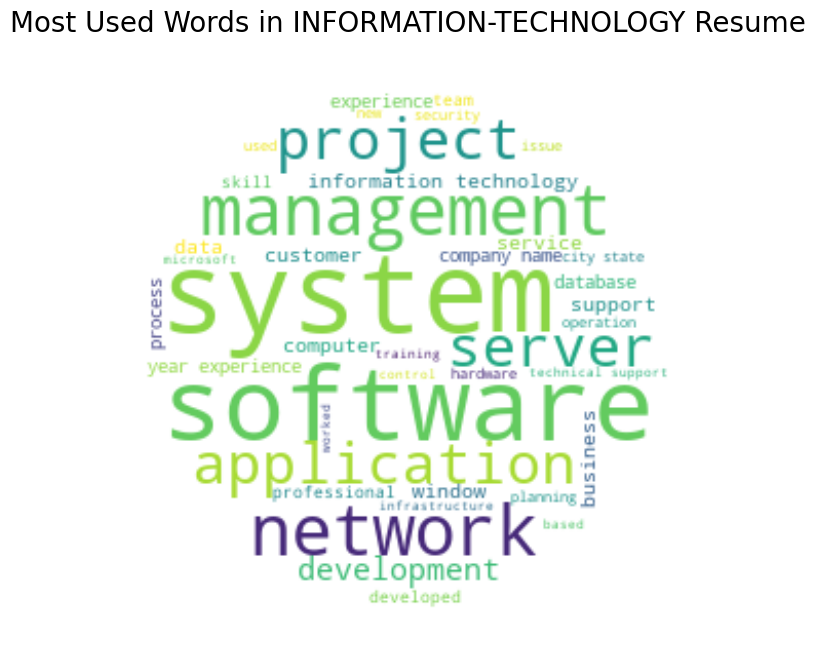

In [46]:
text = ""
for i in data[data["Category"] == Job_Category]["Clean_Resume"].values:
    text += i + " "
    
plt.figure(figsize=(8,8))

x , y = np.ogrid[ :300, :300]

mask = (x-150)**2 + (y-150)**2 > 130**2
mask = 255*mask.astype(int)

wc = WordCloud(
    width = 800,
    height = 800,
    background_color="white",
    min_font_size=6,
    repeat=True,
    mask=mask,
)
wc.generate(text)

plt.axis("off")
plt.imshow(wc, interpolation="bilinear")
plt.title(f"Most Used Words in {Job_Category} Resume", fontsize=20)

# Entity Recognition

We can also display various entities within our raw text by using spaCy displacy.render. I am in love with this function as it is an amazing way to look at your entire document and discover SKILL or GEP within your Resume.

In [47]:
sent = nlp(data["Resume_str"].iloc[0])
displacy.render(sent, style="ent", jupyter=True)

# Dependency Parsing

We can also visualize dependencies by just changing style to dep as shown below. We have also limited words to 10 which includes space too. Limiting the words will make it visualize the small chunk of data and if you want to see the dependency, you can remove the filter.

In [48]:
displacy.render(sent[0:10], style="dep", jupyter=True, options={"distance":90})

# Custom Entity Recognition

In our case, we have added a new entity called SKILL and is displayed in gray color. I was not impressed by colors and I also wanted to add another entity called Job Description so I started experimenting with various parameters within `displace.

•Adding Job-Category into entity ruler.

•Adding custom colors to all categories.

•Adding gradient colors to SKILL and Job-Category

You can see the result below as the new highlighted texts look beautiful.

In [49]:
patterns = df.Category.unique()
for a in patterns:
    ruler.add_patterns([{"label":"Job-Category","pattern": a}])

In [50]:
# options=[{"ents": "Job-Category", "colors": "#ff3232"},{"ents": "SKILL", "colors": "#56c426"}]
colors = {
    "Job-Category": "linear-gradient(90deg, #aa9cfc, #fc9ce7)",
    "SKILL": "linear-gradient(90deg, #9BE15D, #00E3AE)",
    "ORG": "#ffd966",
    "PERSON": "#e06666",
    "GPE": "#9fc5e8",
    "DATE": "#c27ba0",
    "ORDINAL": "#674ea7",
    "PRODUCT": "#f9cb9c",
}
options = {
    "ents": [
        "Job-Category",
        "SKILL",
        "ORG",
        "PERSON",
        "GPE",
        "DATE",
        "ORDINAL",
        "PRODUCT",
    ],
    "colors": colors,
}
sent = nlp(data["Resume_str"].iloc[5])
displacy.render(sent, style="ent", jupyter=True, options=options)

# Your Resume Analysis

In [51]:
input_resume = "Harsh S. Patel Data Scientist I am a certified data scientist professional, who loves building machine learning models and blogs about the latest AI technologies. I am currently testing AI Products at PEC-PITC, which later gets approved for human trials. abidaliawan@tutamail.com +923456855126 Islamabad, Pakistan abidaliawan.me WORK EXPERIENCE Data Scientist Pakistan Innovation and Testing Center - PEC 04/2021 - Present, Islamabad, Pakistan Redesigned data of engineers that were mostly scattered and unavailable. Designed dashboard and data analysis report to help higher management make better decisions. Accessibility of key information has created a new culture of making data-driven decisions. Contact: Ali Raza Asif - darkslayerraza10@gmail.com Data Scientist Freelancing/Kaggle 11/2020 - Present, Islamabad, Pakistan Engineered a healthcare system. Used machine learning to detect some of the common decisions. The project has paved the way for others to use new techniques to get better results. Participated in Kaggle machine learning competitions. Learned new techniques to get a better score and finally got to 1 percent rank. Researcher / Event Organizer CREDIT 02/2017 - 07/2017, Kuala Lumpur, Malaysia Marketing for newly build research lab. Organized technical events and successfully invited the multiple company's CEO for talks. Reduced the gap between industries and educational institutes. Research on new development in the IoT sector. Created research proposal for funding. Investigated the new communication protocol for IoT devices. Contact: Dr. Tan Chye Cheah - dr.chyecheah.t@apu.edu.my EDUCATION MSc in Technology Management Staffordshire University 11/2015 - 04/2017, Postgraduate with Distinction Challenges in Implementing IoT-enabled Smart cities in Malaysia. Bachelors Electrical Telecommunication Engineering COMSATS Institute of Information Technology, Islamabad 08/2010 - 01/2014, CGPA: 3.09 Networking Satellite communications Programming/ Matlab Telecommunication Engineering SKILLS Designing Leadership Media/Marketing R/Python SQL Tableau NLP Data Analysis Machine learning Deep learning Webapp/Cloud Feature Engineering Ensembling Time Series Technology Management ACHIEVEMENTS 98th Hungry Geese Simulation Competition (08/2021) 2nd in Covid-19 vaccinations around the world (07/2021) 8th in Automatic Speech Recognition in WOLOF (06/2021) Top 10 in WiDS Datathon. (03/2021) 40th / 622 in MagNet: Model the Geomagnetic Field Hosted by NOAA (02/2021) 18th in Rock, Paper, Scissors/Designing AI Agent Competition. (02/2021) PROJECTS Goodreads Profile Analysis WebApp (09/2021) Data Analysis Web Scraping XLM Interactive Visualization Contributed in orchest.io (08/2021) Testing and Debuging Technical Article Proposing new was to Improve ML pipelines World Vaccine Update System (06/2021) Used sqlite3 for database Automated system for daily update the Kaggle DB and Analysis Interactive dashboard mRNA-Vaccine-Degradation-Prediction (06/2021) Explore our dataset and then preprocessed sequence, structure, and predicted loop type features Train deep learning GRU model Trip Advisor Data Analysis/ML (04/2021) Preprocessing Data, Exploratory Data analysis, Word clouds. Feature Engineering, Text processing. BiLSTM Model for predicting rating, evaluation, model performance. Jane Street Market Prediction (03/2021) EDA, Feature Engineering, experimenting with hyperparameters. Ensembling: Resnet, NN Embeddings, TF Simple NN model. Using simple MLP pytorch model. Achievements/Tasks Achievements/Tasks Achievements/Tasks Thesis Courses"

In [52]:
sent2 = nlp(input_resume)
displacy.render(sent2, style="ent", jupyter=True, options=options)

# Match Score

In [53]:
input_skills = "Data Science,Data Analysis,Database,SQL,Machine Learning,tableau"

In [54]:
req_skills = input_skills.lower().split(",")
resume_skills = unique_skills(get_skills(input_resume.lower()))
score = 0
for x in req_skills:
    if x in resume_skills:
        score += 1

req_skills_len = len(req_skills)
match = round(score / req_skills_len* 100,1)

print(f"The current Resume is {match}% matched to your requirements")

The current Resume is 66.7% matched to your requirements


We can also see the skills mentioned in your resume

In [55]:
print(resume_skills)

['communications', 'database', 'testing', 'pytorch', 'exploratory data analysis', 'ml', 'nlp', 'text processing', 'tableau', 'machine learning', 'visualization', 'time series', 'simulation', 'speech recognition', 'marketing', 'data analysis', 'deep learning', 'engineering', 'ai', 'python']


# Topic Modeling - LDA

In [56]:
docs = data["Clean_Resume"].values
dictionary = corpora.Dictionary(d.split() for d in docs)
bow = [dictionary.doc2bow(d.split()) for d in docs]
lda = gensim.models.ldamodel.LdaModel
num_topics = 4
ldamodel = lda(
    bow,
    num_topics=num_topics,
    id2word = dictionary,
    passes = 50,
    minimum_probability=0
)
ldamodel.print_topics(num_topics=num_topics)

[(0,
  '0.017*"system" + 0.008*"data" + 0.006*"support" + 0.006*"server" + 0.006*"software" + 0.006*"application" + 0.006*"state" + 0.006*"project" + 0.006*"management" + 0.005*"company"'),
 (1,
  '0.012*"company" + 0.011*"business" + 0.011*"management" + 0.010*"sale" + 0.010*"state" + 0.009*"city" + 0.008*"marketing" + 0.008*"development" + 0.008*"name" + 0.007*"project"'),
 (2,
  '0.012*"state" + 0.012*"city" + 0.012*"customer" + 0.011*"company" + 0.009*"service" + 0.009*"name" + 0.006*"skill" + 0.005*"management" + 0.005*"office" + 0.005*"work"'),
 (3,
  '0.011*"state" + 0.009*"city" + 0.009*"company" + 0.008*"management" + 0.007*"name" + 0.006*"employee" + 0.005*"training" + 0.005*"program" + 0.004*"project" + 0.004*"developed"')]

# pyLDAvis

The best way to visualize Topics is to use pyLDAvis from GENSIM.

•topic #1 appears to relate to the customer, state, and city.

•topic #2 relates to management and marketing.

•topic #3 relates to systems and projects.

•topic #4 relates to financial and company.

In [57]:
pyLDAvis.enable_notebook()
pyLDAvis.gensim_models.prepare(ldamodel, bow , dictionary)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.060767  0.032027       1        1  38.244937
1     -0.039690 -0.102245       2        1  29.751452
0      0.145673  0.005569       3        1  19.680911
3     -0.045216  0.064649       4        1  12.322700, topic_info=           Term        Freq       Total Category  logprob  loglift
644      system  705.000000  705.000000  Default  30.0000  30.0000
238   marketing  347.000000  347.000000  Default  29.0000  29.0000
347        sale  553.000000  553.000000  Default  28.0000  28.0000
1045     server  172.000000  172.000000  Default  27.0000  27.0000
71     business  679.000000  679.000000  Default  26.0000  26.0000
...         ...         ...         ...      ...      ...      ...
358       skill   52.558096  608.283845   Topic4  -5.7452  -0.3550
573      office   47.452563  387.155848   Topic4  -5.8474  -0.0054
305     process   47.687934  428.590953   Topic4  -5.8424  -0.1021
644      system   48.404572  705.577949   Topic4  -5.8275  -0.5857
383        team   44.712927  576.156594   Topic4  -5.9068  -0.4624

[360 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
2634      1  0.945488    00
2         1  0.232537    01
2         2  0.697610    01
2         3  0.049476    01
2         4  0.019790    01
...     ...       ...   ...
403       4  0.121722  work
406       1  0.403484  year
406       2  0.306648  year
406       3  0.132343  year
406       4  0.154938  year

[707 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 2, 1, 4])

# Conclusion

In this project, we have used an entity ruler to create additional entities and then displayed them using custom colors. We have also visualized categories and skills distributions and allowed the user to add resumes directly which includes skills match percentage. Finally, we have used LDA for topic modeling and used pyLDAvis to visualize various topics.

Overall, it was a learning experience for me as I have never used spaCy in depth. I have also discovered various ways on how my project can be used to improve the hiring process in filtering out the perfect candidate for the job. I hope you like my project and don't forget to give ♥.